# Tissue setup
That is the file that explain how the "machine" file Tissue.py works and how I made my decisions

In [2]:
#import
import math
import scipy as sp
import numpy as np

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from Additional_functions import Imp

Start by importing all the images: the one that we'll use as a example, the reference image, the trademark and the written tissue

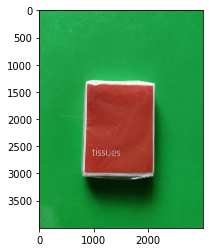

In [3]:
tis, TIS, filtis, FILTIS = Imp("Photos/Tissue/S1.jpg")
#Q at the beginning stand for query 
qtis, QTIS, qfiltis, QFILTIS = Imp("Photos/Tissue/Query_tissue.jpg")

#Import the tissue write image
st, ST, filst, FILST = Imp("Photos/Tissue/scritta_tissue.png")
#the trademark print by a PC
ttis, TTIS = Imp("Photos/Tissue/tissue.png")[:2]

plt.imshow(FILTIS)
plt.show()

First of all, detect the presence of the product. We provide a template match and then see if the area of the match correspond to a possible area of the tissue. Then, if the product is detected, we can compute its position precisely and from that get the orienattion and the defects

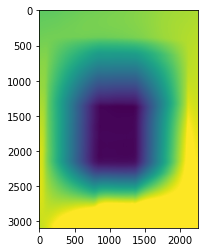

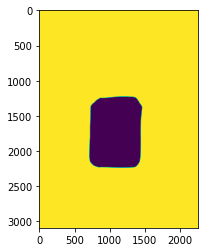

697898
Object detected


In [4]:
#template match
match = cv2.matchTemplate(FILTIS, TTIS, cv2.TM_SQDIFF_NORMED)
plt.imshow(match)
plt.show()
#The area of the match is within certain values of match function
threshold_match = 0.2
#create a binarized image where there's 0 where there's no match and 1 where there's match
match_area = np.where(match <= threshold_match, 0, match)
match_area = np.where(match > threshold_match, 1, match_area)
plt.imshow(match_area)
plt.show()
h,w = np.shape(match)

#count the 1 (the yellow part)
pixel_area_sub = np.count_nonzero(match_area)
#then remove it from the area and we are left with the purple area 
pixel_area = h*w - pixel_area_sub

print(pixel_area)


#if pixel area is between 400000 and 800000 is ok, threshold found in practice through geometric consideration

low_threshold = 400000
high_threshold = 800000
if pixel_area > low_threshold & pixel_area < high_threshold:
    print("Object detected")
else:
    if pixel_area < low_threshold:
        print("object not detected")
    if pixel_area > high_threshold:
        print("More objects detected")

# Localization
Given the fact that there's the product, let's try to localize it precisely. in this scenario, it's not for sure that the SIFT is the best choice given the small amount of features that the product present

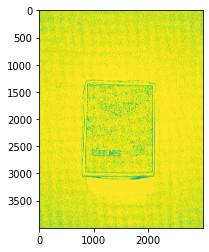

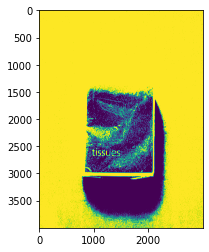

The percentage of correspondence is: 0 %


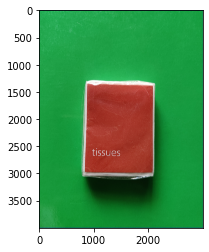

In [5]:
thresh = cv2.adaptiveThreshold(filtis, maxValue = 255, adaptiveMethod = cv2.BORDER_REPLICATE, thresholdType = cv2.THRESH_BINARY, blockSize = 7, C = 5)
tv, thresh2 = cv2.threshold(filtis, 120, 255, cv2.THRESH_OTSU)
plt.imshow(thresh)
plt.show()
plt.imshow(thresh2)
plt.show()
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh2, connectivity = 4, ltype = cv2.CV_32S)

max_area_index = np.argmax(stats[:,4]) 
max_area = stats[max_area_index, 4]
x = stats[max_area_index, cv2.CC_STAT_LEFT]
y = stats[max_area_index, cv2.CC_STAT_TOP]
width = stats[max_area_index, cv2.CC_STAT_WIDTH]
heigth = stats[max_area_index, cv2.CC_STAT_HEIGHT]
Tisbd = cv2.rectangle(TIS, (stats[max_area_index, cv2.CC_STAT_LEFT], stats[max_area_index, cv2.CC_STAT_TOP]), (stats[max_area_index, cv2.CC_STAT_LEFT] +stats[max_area_index, cv2.CC_STAT_WIDTH], stats[max_area_index, cv2.CC_STAT_TOP] + stats[max_area_index, cv2.CC_STAT_HEIGHT]), (0, 0, 255), 5)

#Check. assume for semplicity that the tissue is in the middle, so that the template match has taken half of the pixel
#at right and half of the pixel at left from the image (right and left wrt the match)
h,w = np.shape(filtis)
region1 = match[-np.int32(h/2) + y: y + heigth - h, -np.int32(w/2)+x: x + width - w]
region2 = np.where(match_area == 0)
#region2 = region2.reshape(-1, 2)
region_x = region2[1]
region_y = region2[0]
counter_coincident = 0 
counter_element = 0
for i in range (0, np.size(region_x)):
    counter_element = counter_element + 1
    if region_y[i] < y + heigth - h and region_y[i] > -np.int32(h/2) + y and region_x[i] > -np.int32(w/2)+x and region_x[i] < x + width - w:
        counter_coincident = counter_coincident +1

ratio = counter_coincident/counter_element
print("The percentage of correspondence is:", np.int32(ratio*100),"%")
if ratio >= 0.8:
    print("Correspondence found, product is detected and bounded")
plt.imshow(Tisbd)
plt.show()


The connected component approach doesn't work because it processes a binarized image. To binarize the image, if we pick the gray scale histogram of the gray scale image, there is a "white" zone near 255 of which don't care, a "black" zone near 0 that represent the shadows, an orange zone near 80 and a green zone near 110. The goal of course is to separate the orange from the green so we'll pick a threshold between 80 and 110 (OTSU gives 89 in fact). But doing this we classify the black shadows as the orange part (it become a false foreground), so that's were the problem is.

# SIFT (also this time)
I have to setup the SIFT descriptor in order to find out the true correspondences and then evenually compute the difference as in the toothpaste case. Anyway with the template match we can verify that there's a piece on the conveyor, so if there's not we avoid the computation of the online SIFT  

[[[ 860.0777 1308.1515]]

 [[ 818.3982 3007.7896]]

 [[2098.793  3006.484 ]]

 [[2098.3828 1333.0472]]]


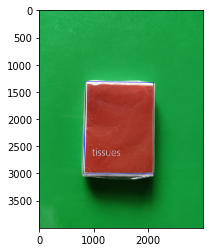

In [6]:
sift = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 1
#low value, we don't have so much features as in the other 2 products
MIN_MATCH_COUNT = 20
kp_query = sift.detect(QFILTIS)
kp_query, des_query = sift.compute(QFILTIS, kp_query)

kp_train = sift.detect(FILTIS)
kp_train, des_train = sift.compute(FILTIS, kp_train)

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query,des_train,k=2)
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance: #0.8 degree of freedom, index of acceptability of a keypoint
        good.append(m)

h,w = qfiltis.shape
if len(good) >= MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 9.0)
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M1)
    print(dst)
    #Blue lines because the green would be too similar to the background
    PIC = cv2.polylines(FILTIS, [np.int32(dst)], True, (0, 0, 255), 5, cv2.LINE_AA)

    plt.imshow(PIC)
    plt.show()

And follows, also in this case, the warping procedure to create a more accurated overlapping between the reference image and the detected one.

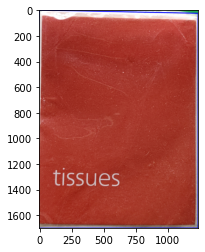

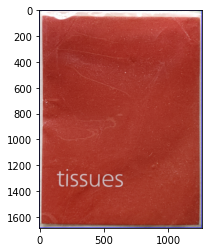

In [8]:
dst = np.int32(dst.reshape(4,2))

TIS_CUT = FILTIS[dst[0,1]:dst[2,1], dst[0,0]:dst[2,0]]

plt.imshow(TIS_CUT)
plt.show()

dst = np.int32(dst.reshape(4,2))
parallelogram_vertices = np.array([[dst[0,0], dst[0,1]], [dst[1,0], dst[1,1]], [dst[2,0], dst[2,1]], [dst[3,0], dst[3,1]]], dtype=np.float32)

#nh and nw computed as the mean between the sides
nh = np.int32((dst[1,1]-dst[3,1]+dst[2,1]-dst[0,1])/2)
nw = np.int32((-dst[1,0]-dst[0,0]+dst[2,0]+dst[3,0])/2)
# Define the vertices of the destination rectangle
rectangle_vertices = np.array([[0, 0], [0, nh], [nw, nh], [nw,0]], dtype=np.float32)

# Calculate the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(parallelogram_vertices, rectangle_vertices)

# Apply the perspective transformation
warped_image = cv2.warpPerspective(FILTIS, perspective_matrix, (nw,nh))

plt.imshow(warped_image)
plt.show()

And resize also the reference image to make it "subtractable" to the warped one

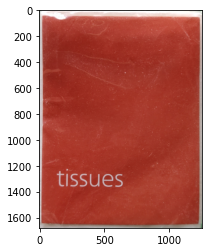

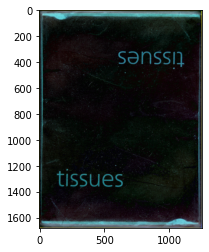

In [22]:
image_resized = cv2.resize(QFILTIS, (warped_image.shape[1], warped_image.shape[0]), interpolation=cv2.INTER_AREA)
plt.imshow(image_resized)
plt.show()
diff = cv2.absdiff(image_resized, warped_image)
plt.imshow(diff)
plt.show()

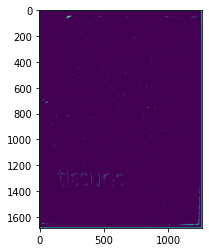

In [10]:
#binarize
gray_diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)

binary_diff = cv2.threshold(gray_diff, 50, 255, cv2.THRESH_BINARY)[1]
plt.imshow(binary_diff)
plt.show()

We note that there are some little isolated differences, in this case the image has no difference, so as toothpaste, we close it and then with the help of a treshold define the goodness of the product

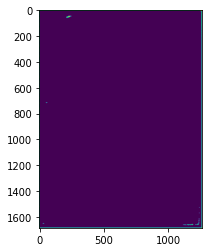

In [11]:
size_k = 3
kernel = np.zeros((size_k, size_k))
kernel[:] = 1
opened_diff = cv2.morphologyEx(binary_diff, cv2.MORPH_OPEN, kernel)
plt.imshow(opened_diff)
plt.show()

In [12]:
ht, wt = np.shape(opened_diff)
area = ht*wt
difference_pixel = np.count_nonzero(opened_diff)
print(difference_pixel)

ratio = difference_pixel/area
#given the fact we don't provide the mask and that there could be light issues due to the reflectent
#plastic that wrap the tissue we raise a bit the value of acceptability
acceptability = 0.02

if ratio > acceptability:
    print("The product is defectful")
else:
    print("The product is OK")

23336
The product is OK


# Orientation
Now if the product is good, check wheter it has to be turned or not. The only discriminant we have to establish the orientation is the position of the written "tissue". We provide 2 approach, the first is basic and simple and relies on the fact that the written is in the right, otherwise the qaulit control qouldn,t be passed. The second approach is an overkill but, at least, we are sure of the result
1. Binarize the image of the tissue, binarize it and then find the side with most whites: if it's the lowest one (the side in which the written is supposed to be) product is correctly turned, otherwise we have to turn it. Also the border are whites, this is why this approach could be dangerous
2. We train a further SIFT descriptor to localize precisely the written, then we repeat the procedure: if it's in the lower part product ok, otherwise must be turned


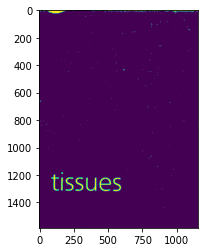

Product is turned correctly


In [22]:
half_h = np.int32(ht/2)
cut_f = 50
cut_img = warped_image[cut_f:-cut_f, cut_f:-cut_f]
cut_img = cv2.cvtColor(cut_img, cv2.COLOR_RGB2GRAY)
thresh_white = cv2.threshold(cut_img, 150, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh_white)
plt.show()
thres_up = thresh_white[:half_h,:]
thresh_down = thresh_white[half_h:,:]

white_up = np.count_nonzero(thres_up)
white_down = np.count_nonzero(thresh_down)
if white_down > white_up:
    print("Product is turned correctly")
else:
    print("Product must be turned")


# Turned object pipeline
That pipeline is good for recognize an object well oriented, but in case the object is flipped upside down, there are other adjustments we have to provide. Let's import a flipped tissue and see.

[[-8.83614077e-01 -5.80994604e-03  2.07537163e+03]
 [ 7.12226187e-03 -9.09431905e-01  2.67375088e+03]
 [ 6.64730887e-06 -8.40029377e-06  1.00000000e+00]]
[[[2075.3716  2673.751  ]]

 [[2097.491    985.8968 ]]

 [[ 831.88776  986.69867]]

 [[ 829.7014  2658.9666 ]]]


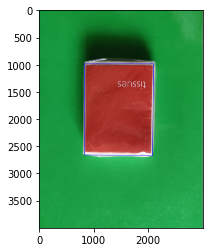

In [12]:
ftis, FTIS, ffiltis, FFILTIS = Imp("Photos/Tissue/S2.jpg")

kp_train = sift.detect(FFILTIS)
kp_train, des_train = sift.compute(FFILTIS, kp_train)

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query,des_train,k=2)
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance: #0.8 degree of freedom, index of acceptability of a keypoint
        good.append(m)

h,w = qfiltis.shape
if len(good) >= MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 9.0)
    print(M1)
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M1)
    print(dst)
    #Blue lines because the green would be too similar to the background
    PIC2 = cv2.polylines(FFILTIS, [np.int32(dst)], True, (0, 0, 255), 5, cv2.LINE_AA)

    plt.imshow(PIC2)
    plt.show()

M1 in this case is characterized by both rotation element negative on the main diagonal 

In [16]:
dst = np.int32(dst.reshape(4,2))
if M1[0,0]< 0 and M1[1,1] < 0:
    dst = np.roll(dst, shift=2, axis = 0)
    print(dst)

[[ 831  986]
 [ 829 2658]
 [2075 2673]
 [2097  985]]


The dst vector has the same form as the previous one but it's not the same, now the first rows refers to the right below corner of the tissue (that in fact in the flipped image is upside left). Let's see if the warping procedure works the same

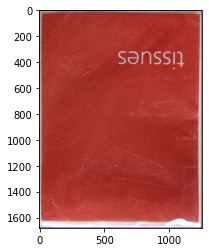

In [18]:

parallelogram_vertices = np.array([[dst[0,0], dst[0,1]], [dst[1,0], dst[1,1]], [dst[2,0], dst[2,1]], [dst[3,0], dst[3,1]]], dtype=np.float32)

nh = np.int32((dst[1,1]-dst[3,1]+dst[2,1]-dst[0,1])/2)
nw = np.int32((-dst[1,0]-dst[0,0]+dst[2,0]+dst[3,0])/2)
# Define the vertices of the destination rectangle
rectangle_vertices = np.array([[0, 0], [0, nh], [nw, nh], [nw,0]], dtype=np.float32)

# Calculate the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(parallelogram_vertices, rectangle_vertices)

# Apply the perspective transformation
warped_image = cv2.warpPerspective(FFILTIS, perspective_matrix, (nw,nh))
plt.imshow(warped_image)
plt.show()

It worked out, but we still have to flip the image before computing the difference

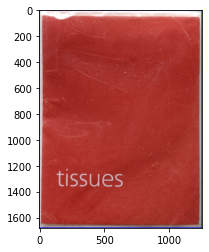

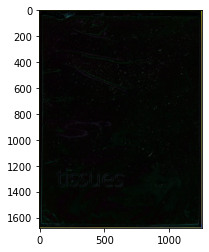

In [23]:
if M1[0,0] < 0 and M1[1,1] < 0:
    warped_image = cv2.rotate(warped_image, cv2.ROTATE_180)

plt.imshow(warped_image)
plt.show()
diff = cv2.absdiff(image_resized, warped_image)
plt.imshow(diff)
plt.show()

# Final orientation 
Analyzing the flipped image it comes out that we can just use the values given by the homography to verify the orientation and avoid all the computation due to the white checks and the written. In this scenario, for the sake of simplicity, we analyze the case of rotation of 180 (actually because in the machine there was not a mechanism to rotate precisely the tissue pack as the servo for the stick) butwe can extend this approach to every rotation between 0 and 360 degrees:
1. Get the angle from the homography matrix
2. Get and warp the image cut in a rectangular form suitable to compute the difference
3. Compute the difference and provide all the filtering/mask/binarization required

# Another way to compute the difference

given that the most of the area is characterized by an orange like color, we can extract the written tissue with SIFT, from that derive the orientation, and then compute the difference in the rest of the tissue as a difference with respect to the reference orange color. That could be potentially more accurate, but the problem is that we wouldn't know if the position of the written is right. 